In [70]:
import abc
from collections import Counter
import json

import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_score 
from scipy.spatial.distance import squareform, pdist

In [71]:
plt.rc('font', size = 12)
from IPython.display import Latex, Math
from IPython.display import Image
from IPython.core.display import display,HTML
#display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

## Data

The purchasing power parity gross domestic product (GDP (PPP)) have been obtained from the paper of [James and Gakidou](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3487911/). The reference currency is the 2005 USD defined according to the IMF.

Time series spans between 1950 and 2018 contains points for 210 countries or territories (countries for short in the following). 

### Data format

The time series' are loaded to a `pandas` dataframe. The countries are encoded by their three letter ISO 3166-1 alpha-3 abbreviations as row indices. Each year is stored in a separate column.

In [72]:
path_to_db = r'C:\Users\Balazs\source\repos\GDP\data\1478-7954-10-12-S3.xlsx'
sheet_name = 'Sheet1'

df = pd.read_excel(path_to_db, sheet_name = sheet_name, header = None)

# split columns by countries
groups = df.groupby(0)
df = pd.DataFrame.from_dict({n : g[1].values for n, g in groups}, orient = 'index')

df.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
ABW,1266.2420,1327.6650,1393.9080,1467.9210,1546.2200,1623.0460,1717.7520,1792.5970,1867.8290,1943.5910,...,20333.6900,20143.8800,19444.6300,15729.5800,16451.7000,17275.2300,18179.3200,19139.9100,20157.2100,21228.3800
AFG,179.4909,182.1864,185.5338,192.9397,194.3511,195.4881,200.4814,198.2413,204.9097,207.1753,...,263.0708,292.6143,294.5654,351.5893,372.7821,387.9407,404.6445,419.7369,436.9097,455.4637
AGO,1164.6930,1192.4080,1220.7880,1248.8910,1212.4560,1281.8420,1252.5360,1338.9390,1385.0590,1377.6910,...,2289.3820,2675.2520,2945.2890,2878.3360,2958.8980,3076.2210,3174.6280,3268.8260,3347.4790,3384.9220
AIA,1443.0830,1502.3340,1566.0870,1637.5250,1712.6170,1784.9380,1875.6700,1943.4890,2010.6670,2077.3580,...,13845.4000,15838.2700,15682.0600,11612.8400,12059.6800,12573.3900,13137.4100,13733.3200,14360.5000,15016.1900
ALB,778.0425,809.2832,814.2191,845.1029,869.4968,912.0341,923.9318,976.7833,1017.5170,1056.7130,...,2731.5010,2889.3540,3093.5480,3179.8590,3246.2210,3333.4310,3436.3720,3562.8720,3711.6290,3877.9590


### General trends

Firstly, we investigate how GDPs have changed over time. To this end, a histogram is created in which each bin corresponds to 2% of the maximum GDP of all years.

In [73]:
def create_histogram(X, bins = None):
    """
    Creates a histogram for all colmns.
    Parameters:
        X (np.ndarray (n_row, n_col)) : raw data
        bins (None or np.histogram bins) : the bins. If None, 50 equal width bins are created in 
        the [0, np,max(X)] range
    Returns:
        hst (np.ndarray (50, n_col)) : histogram
    """
    
    if bins is None:
        bins = np.linspace(0, np.max(X), num = 50)
    
    hst = np.array([np.histogram(x, bins = bins, density = True)[0] for x in X.T])
    hst = hst * np.diff(bins)
    return hst

In [74]:
histo_year = create_histogram(df.values)

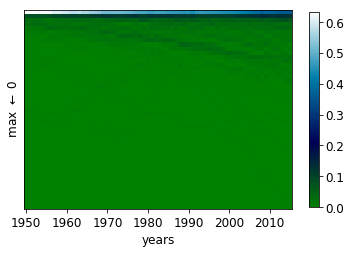

In [75]:
# TO HIDE

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 6)

ax.imshow(histo_year.T, cmap = plt.cm.ocean)
fig.colorbar(ll, ax = ax, shrink = 0.6)
ax.set_xticklabels(['1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010'])
ax.set_xlabel("years")
ax.set_ylabel(r' max $\leftarrow$ 0 ')
ax.set_yticks([], [])
plt.show()

It is readily seen the maximum and overall GDPs have increased over the years. The distribution has become more spread out.

#### Moments

The median and the first four moments of the GDP distribution are plotted below. It is worth comparing the median and the mean. Both of them steadily increase, (apart from the years following the collapse of the Eastern Block between 1989--1991). However, the median shows an increase of 450% whereas the mean only tripled. This means the countries, in general, became richer with respect to the whole distribution. This is also seen in the overall reduction of skew. The median, however, decreased by ~20% after 1990 compared to the dent of ~2% in the mean. This implies those countries with lower GDPs were hit harder than those with higher GDPs.

In [76]:
df_year_stats = pd.DataFrame({'mean' : df.mean(axis = 0),
                              'median' : df.median(axis = 0),
                              'std' : df.std(axis = 0), 
                              'skew' : df.skew(axis = 0)})

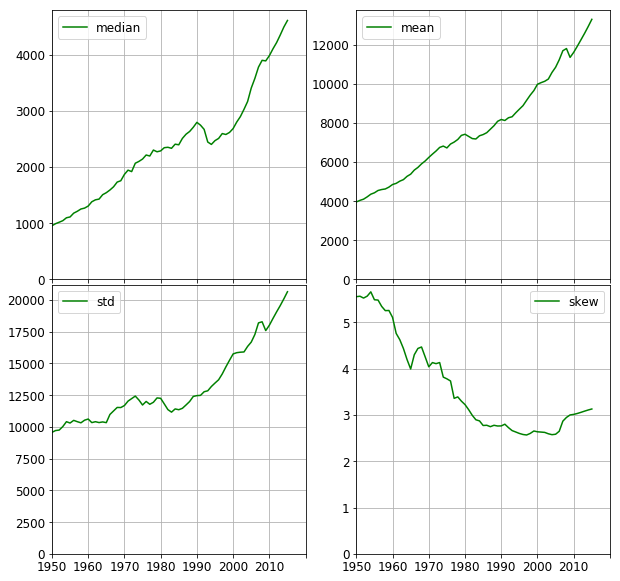

In [77]:
# TO HIDE

fig, axes = plt.subplots(2, 2, sharex = True, gridspec_kw = {'hspace' : 0.02} )
fig.set_size_inches(10, 10)
labels = ['median', 'mean', 'std', 'skew']

for ax, label in zip(axes.flat, labels):
    ax.plot(np.arange(len(df_year_stats)), df_year_stats[label], label = label, color = 'green')
    ax.legend()
    ax.grid(True)
    ax.set_xlim((0,70))
    ax.set_ylim(bottom = 0)
    ax.set_xticklabels(['1950', '1960', '1970', '1980', '1990', '2000', '2010'])
plt.show()

### Relative GDP

It is revealing to compare the GDPs to their maximum value in each year. In doing so, the relative wealth distribution can be assessed.  The `df_scaled_year_stats` lists the median, mean and standard deviation of relative to the highest GDP in each year. 

In [78]:
def scale_by_max(X):
    maxval = np.max(X)
    
    if maxval == 0.0:
        maxval = 0.0
    scaled = X / maxval

    return scaled

In [79]:
df_scaled = df.apply(scale_by_max, axis = 0)

df_scaled_year_stats = pd.DataFrame({'maximum' : df.max(axis = 0),
                                     'mean' : df_scaled.mean(axis = 0),
                                     'median' : df_scaled.median(axis = 0),
                                     'std' : df_scaled.std(axis = 0)})

In [80]:
histo_scaled_year = create_histogram(df_scaled.values)

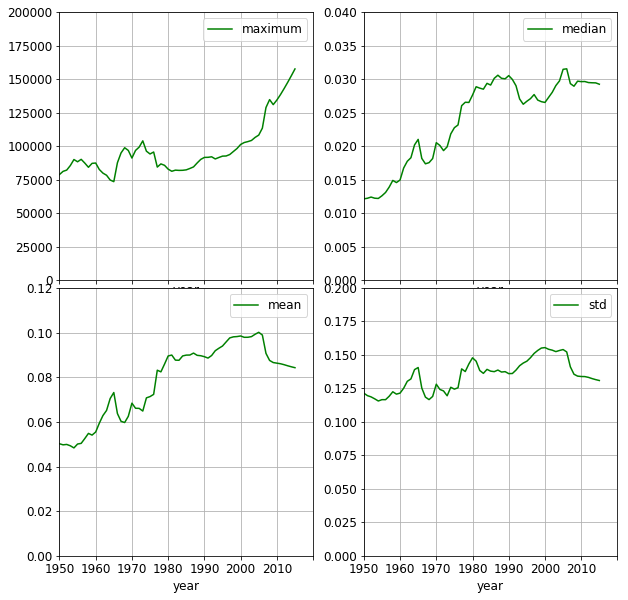

In [81]:
# TO HIDE

fig, axes = plt.subplots(2, 2, sharex = True, gridspec_kw = {'hspace' : 0.03})
fig.set_size_inches(10, 10)

labels = ['maximum', 'median', 'mean', 'std']
ylims = [(0, 200000), (0, 0.04), (0,0.12), (0,0.2)]

for ax, ylim, label in zip(axes.flat, ylims, labels):
    
    ax.plot(np.arange(len(df_scaled_year_stats)), df_scaled_year_stats[label], label = label, color = 'green')
    ax.legend()
    
    ax.grid(True)
    ax.set_xlabel("year")
    ax.set_ylim(ylim)
    ax.set_xlim((0, 70))
    ax.set_xticklabels(['1950', '1960', '1970', '1980', '1990', '2000', '2010'])
    
plt.show()

The wealth of the countries has been increasing relative to that of the wealthiest one as time progresses. In the year of 1950, 70% percent of the countries has a GDP not exceeding 2% of the corresponding maximum.  By 2010, this ratio becomes 40%.  

Further signs of equalisation, that the mean doubles and the median triples. It is still astounding, though, that half of the countries only have at most 3% of the maximum GDP. It is also interesting to observe, that the separation between the wealthiest country and the rest has been increasing since the middle of previous decade. This effect was moderated by the crisis in 2008, as shown by the less negative slope of the _mean_ and _std_ curves.

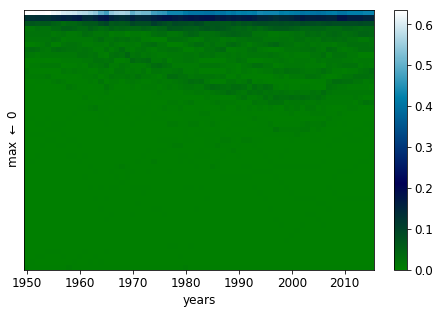

In [82]:
# TO HIDE

fig, ax = plt.subplots(1, 1, constrained_layout = True)
fig.set_size_inches(6, 6)

ll = ax.imshow(histo_scaled_year.T, cmap = plt.cm.ocean)

fig.colorbar(ll, ax=ax, shrink=0.6)
ax.set_xticklabels(['1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010'])
ax.set_xlabel("years")
ax.set_ylabel(r' max $\leftarrow$ 0 ')
ax.set_yticks([], [])

plt.show()

#### Entropy

Entropy can measure how uniformly the values are distributed between ranges of equal width. The bins are taken from the histogram above, that is each bin corresponds to $ 0.02\cdot (\text{GDP}_{max}- 0)$ If $w_{ij} \in \left[0, 1 \right]$ is the value of the _i_ -th in the _j_-th year, the entropy can be calculated as

$$
H(j) = -\sum\limits_{i = 1}^{N_{bins}}w_{ij}\ln w_{ij}
$$
The entropy is then normalised by the maximum possible value of entropy, where each bin has equal number of countries.

$$
\tilde{H(j)} = \frac{H(j)} { -ln(N_{bins})} \in \left[0, 1\right]
$$

The entropy increases over the decades, indicating the GDPs becoming less concentrated around one value i.e. the bins become more evenly populated. It does not, however, states anything about the values themselves. No matter whether 90% being in the bin and 10% being in the last bin or _vica versa_, they would both result in the same entropy. Nevertheless, entropy can provide us with a single number indicator, how uniform the GDP distribution is. Please note, if all countries had equal wealth, the entropy would be zero - all values in one slot. The entropy thus is not suitable to measure inequality. To that end we will invoke the Gini coefficient. 

In [83]:
entropy = calc_entropy(histo_year)
entropy_scaled = calc_entropy(histo_scaled_year)

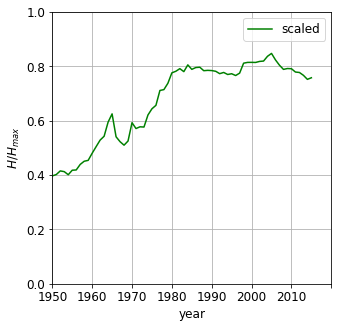

In [84]:
# TO HIDE

fig, axis = plt.subplots(1, 1)
fig.set_size_inches(5, 5)

axis.grid(True)
axis.set_xlabel("year")
axis.set_ylabel(r'$H / H_{max}$')
axis.set_ylim((0.0, 1.0))
axis.set_xlim((0, 70))
axis.set_xticklabels(['1950', '1960', '1970', '1980', '1990', '2000', '2010'])
#axis.plot(np.arange(66), entropy, label = 'raw')
axis.plot(np.arange(66), entropy_scaled, label = 'scaled', color = 'green')
axis.legend()
plt.show()

### Inequality - Lorenz curve

The [Lorenz curve](https://en.wikipedia.org/wiki/Lorenz_curve) is the fraction cumulative wealth plotted against the population ratio. If the wealth is equally distributed, the curve is a linear between the points (0, 0) and (1, 1), which line is also an upper bound of the Lorenz curve. The more the curve deviates from the diagonal, the less equal the wealth distribution is. The Gini coefficient is related to the integral of the Lorenz curve. It is the ratio of the area enclosed by the line of equality and the Lorenz curve and the area under the line of equality. It expresses the distance from equality; 0 meaning total equality, 1 complete inequality.

The coefficient decreases over time, by a modest 0.1 point. (Remember, the median in terms of the highest GDP was still 3% in 2015!) The late fall of communism leaves behind a number of poor countries with economic struggles which results in the increase of the coefficient for a good twenty years from the early eighties. By 2000, the Gini coefficient starts to decrease again, showing some countries had started to recover.

In [85]:
lorenz_curve = calculate_lorenz_curve(df.values)
gini_coeff = calculate_gini(df.values)

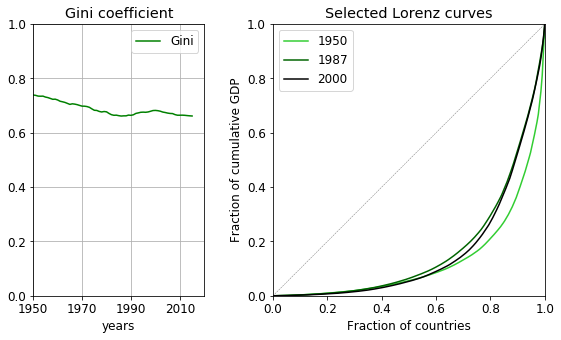

In [86]:
# TO HIDE

lorenz_range = np.linspace(0, 1, num = lorenz_curve.shape[0])
 
fig = plt.figure(figsize=(10, 5))    
grid = plt.GridSpec(1, 6, hspace = 0.2, wspace = 0.3)
ax1 = fig.add_subplot(grid[0,:2])
ax2 = fig.add_subplot(grid[0,2:6])    
    

ax1.grid(True)
ax1.set_xlim(0, 70)
ax1.set_xticklabels(['1950', '1970', '1990', '2010'])
ax1.set_ylim(0.0, 1.0)
ax1.plot(np.arange(gini_coeff.size), gini_coeff, c = 'green', label = 'Gini')
ax1.legend()
ax1.set_title('Gini coefficient')
ax2.set_xlabel('Fraction of countries')
ax2.set_ylabel('Fraction of cumulative GDP')

ax2.plot(lorenz_range, lorenz_curve[:, 0], c = 'limegreen', label = '1950')
ax2.set_aspect('equal')
ax2.set_xlim(0.0, 1.0)
ax2.set_ylim(0.0, 1.0)
ax1.set_xlabel('years')
ax2.plot(lorenz_range, lorenz_curve[:, 37], c = 'darkgreen', label = '1987')
ax2.plot(lorenz_range, lorenz_curve[:, 50], c = 'black', label = '2000')
ax2.plot(lorenz_range, lorenz_range, '--', c = 'grey', linewidth = 0.5)
ax2.legend()
ax2.set_title('Selected Lorenz curves')

plt.show()

## Uncovering groups of countries

We have so far have been concerned with characterising the distribution. A logical next step is to uncover what underlying components form distribution; whether there are groups of countries that evolve similarly over the time.

### Temporal characteristics

If there are countries that move together the correlation between rankings in two subsequent years should show this. We are going to use Spearman's $\rho$ and Kendall's $\tau$ correlations. (Pandas uses `scipy.stats` [Kendall $\tau$ implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html)) which is the $\tau$-b version. Spearman $\rho$ former takes into account the magnitude of changes in two consecutive rankings, whereas Kendall rank correlation calculates the number changes in rankings regardless their magnitude. Therefore Kendall's tau is expected to be more sensitive to any variation of the ranking.

The correlation coefficients are calculated for a number increasing delays, namely 1, 5, 10 and 20 years and are shown below. The almost constant nature of Spearman's $\rho$ indicates that there are no major reorderings in the countries relative positions. However, the minor - or local, if you wish - changes are magnified by Kendall's $\tau$ coefficient.

In [87]:
year_spearman_corr = df.corr(method = 'spearman')
year_kendall_corr = df.corr(method = 'kendall')

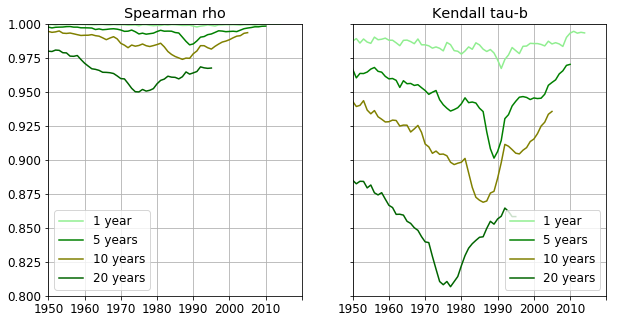

In [88]:
# TO HIDE

fig, axes = plt.subplots(1, 2, sharey = True)
fig.set_size_inches(10, 5)

year_offsets = [1, 5, 10, 20]
year_labels = ['1 year', '5 years', '10 years', '20 years']
colors = ['lightgreen', 'green', 'olive', 'darkgreen']

for ofs, label, color in zip(year_offsets, year_labels, colors):
    y = np.diagonal(year_spearman_corr.values, offset = ofs)
    axes[0].plot(np.arange(y.size), y, label = label, color = color)
    
    y = np.diagonal(year_kendall_corr.values, offset = ofs)
    axes[1].plot(np.arange(y.size), y, label = label, color = color)


axes[0].set_title('Spearman rho'); axes[1].set_title('Kendall tau-b')
axes[0].grid(True); axes[1].grid(True);
axes[0].legend(); axes[1].legend();
axes[0].set_xlim((0,70)); axes[1].set_xlim((0,70))
axes[0].set_ylim((0.8,1.0)); axes[1].set_ylim((0.8, 1.0))
axes[0].set_xticklabels(['1950', '1960', '1970', '1980', '1990', '2000', '2010'])
axes[1].set_xticklabels(['1950', '1960', '1970', '1980', '1990', '2000', '2010'])
plt.show()

The country rankings barely change between two subsequent years. Correlation coefficients at larger delays are indicative of longer term dynamics. E.g. the five year forward coefficient rapidly decreases from 1985 reaching its minimum at 1989, showing that GDP rankings fluctuated between the years 1990 and 1994. From 1989 the correlation increases as the new order stabilises throughout those years. The 10 year forward correlation exhibits a small but noticeable slump starting at 1990. This means the rankings starting at 2000 differ more and more to those ten years earlier. The correlation begins to increase at 1995 so there is again a period of stabilization between 1995 and 2005.

### Clustering

It would be interesting to see whether there are groups of countries whose GDPs move together and are close to each other over time. Provided there are, we wish to find the GDP most characteristic of each group. A number of clustering methods can achieve these goals. To name a few, [k-medoids](https://en.wikipedia.org/wiki/K-medoids), [Markov cluster algorithm (MCA)](https://micans.org/mcl/), [affinity propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation). For MCA has been used on numerous occasions in the previous posts, we are going to choose the k-medoids method. A slim implementation thereof can be found in the bottom of this post.

#### Distance between GDP time series

What distance should be used in the clustering algorithm? We are looking for similarities in two ways
1. the series are close to each other with respect to their values
2. their dynamics are similar

Correlation is insensitive to the proximity of the time series, therefore it is not a good indicator of (1.). The ordinary $L_{2}$ distance ignores the relative magnitude (mean) of the series. This is illustrated in the figure below. $L_{2}$ distance between series (a) and (b) is the same as between series (b) and (c). However, (c) is only 1.5 times greater than (b) whereas (b) is twice the magnitude of (a). 

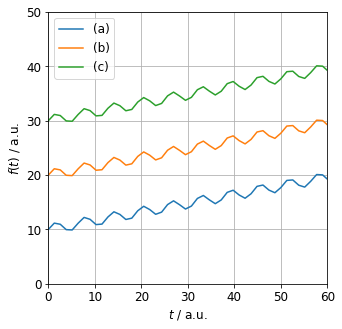

In [89]:
# TO HIDE

x = np.linspace(0.0, 20*np.pi)
y = np.linspace(0.0, 10.0) + np.sin(x) 

fig, ax = plt.subplots(1,1)
fig.set_size_inches(5, 5)

ax.plot(x, y + 10, label = '(a)')
ax.plot(x, y + 20, label = '(b)')
ax.plot(x, y + 30, label = '(c)')
ax.legend()
ax.grid(True)
ax.set_xlim((0.0, 60))
ax.set_ylim((0.0, 50))
ax.set_xlabel(r'$t$ / a.u.')
ax.set_ylabel(r'$f(t)$ / a.u.')
plt.show()

What distance should be used in the clustering algorithm? Correlation is insensitive to the proximity of the timeseries. The $L_{2}$ distance ignores the relative magnitude (mean) of the series. E.g. $L_{2}$ distance between series (a) and (b) is the same as between series (b) and (c). However, (c) is only 1.5 greater than (b) whereas (b) is twice the magnitude of (a). 

The overlap, defined below, takes into account both the similarity of the time dependence as correlation does. The spatial distance is also accounted for in the denominator:

$$
D_{ij} = \frac{\int\limits_{t} (f_{i}(t) - f_{j}(t))^{2} \mathrm{d}t}{\int\limits_{t} f_{i}(t)^{2}\mathrm{d}t +  \int\limits_{t} f_{j}(t)^{2}\mathrm{d}t} = 1 - 2 \cdot \frac{\int\limits_{t} f_{i}(t) \cdot f_{j}(t)\mathrm{d}t}{\int\limits_{t} f_{i}(t)^{2}\mathrm{d}t +  \int\limits_{t} f_{j}(t)^{2}\mathrm{d}t}
$$

This measure is implemented as the `overlap` function below.

In [90]:
overlap = lambda u, v: 1 - 2 * (u * v).sum() / ((u * u).sum() + (v * v).sum())
X = squareform(pdist(df.values, overlap))

#### k-medoids clustering

The optimal number of clusters is unknown thus a range of them is tried out. The goodness of clustering is measured by the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score). The corresponding results are then saved in the `results` list of dictionaries. We do not perform cross validation, for we are interested in grouping all of the countries. 

In [91]:
clusterer = KMedoids()

results = []

for n_clusters in range(2, 30):
    
    clusterer.set_params(n_clusters = n_clusters)
    labels = clusterer.fit_predict(X)
    score = clusterer.score
    sil_score = silhouette_score(X, labels)
    
    results.append({'n_clusters' : n_clusters,
                    'labels' : labels,
                    'sil_score' : sil_score,
                    'score' : score,
                    'medoids' :  clusterer.medoids})

In [92]:
# TO HIDE

for idx in range(len(results)):
    
    medoids = results[idx]['medoids'] + 0
    labels = results[idx]['labels'] + 0
    
    i_sort = np.argsort(df.values[medoids].mean(axis = 1))
    labels_ = np.full_like(labels, -1)

    for label, medoid in enumerate(medoids[i_sort]):
        labels_[labels == i_sort[label]] = label
    
    medoids = medoids[i_sort]
    
    results[idx].update({'medoids' : medoids, 'labels' : labels_})

#### Determining the number of clusters

There are a manifold of ways to ascertain the optimal number of clusters. One can plot the intra-cluster variance as a function of the number of clusters. This number can be the point where the variance decreases only by small amount compared to the previous values. This method would suggest a five as the optimum number of clusters (left panel of figure below). One can alternatively choose the maximum of the [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)). This measure inversely proportional to the intra cluster variance but also penalises the increasing number of clusters. There is a maximum at $n_{clusters} = 3$ and a secondary maximum at $n_{clusters} = 11$.

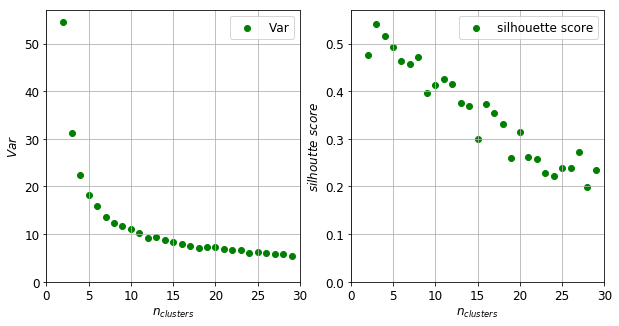

In [93]:
# TO HIDE

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axes[0].scatter([x['n_clusters'] for x in results], [x['score'] for x in results], color = 'green', label = 'Var')
axes[1].scatter([x['n_clusters'] for x in results], [x['sil_score'] for x in results], color = 'green', label = 'silhouette score')
axes[0].legend(); axes[1].legend()
axes[0].grid(True); axes[1].grid(True)
axes[0].set_xlim((0, results[-1]['n_clusters'] + 1)); axes[1].set_xlim((0, results[-1]['n_clusters'] + 1));
axes[0].set_ylim(bottom = 0.0); axes[1].set_ylim(bottom = 0.0)
axes[0].set_xlabel(r'$n_{clusters}$'); axes[1].set_xlabel(r'$n_{clusters}$')
axes[0].set_ylabel(r'$Var$'); axes[1].set_ylabel(r'$silhoutte \,\, score$')
plt.show()

Before making a decision, the first twelve clusters are shown in the figure below. The exemplars of the clusters are drawn with bold lines. The other members of the clusters appear in half tone of the corresponding colors.

In [94]:
# TO HIDE
def plot_line_cluster(lines, medoids, labels, cmap, alpha = 0.1, ax = None):
    
    if ax is None:
        fix, ax = plt.subplots(1, 1)
      
    x = np.arange(lines.shape[1])
    
    lm = np.max(labels)
    legend = r'$n_{0}$ = {1}'.format("{clusters}", lm + 1)
    ax.annotate(legend, (35, 80000))
    
    for label, medoid in enumerate(medoids):
        color = cmap(label / lm)
        
        for line in lines[labels == label]:
            ax.plot(x, line, color = color, alpha = alpha, linewidth = 0.8)
          
        ax.plot(lines[medoid], color = color)
        
    ax.set_xlim((0, x.shape[0] - 1))
    ax.set_ylim((0,100000))

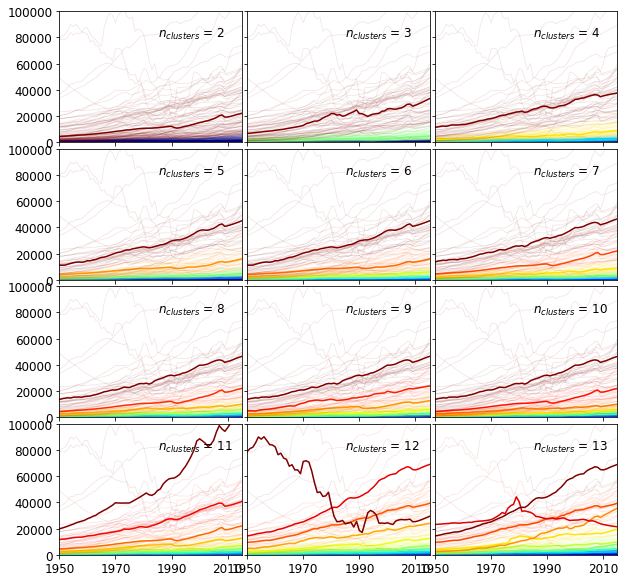

In [95]:
# TO HIDE
fig, axes = plt.subplots(4,3, sharex = True, sharey = True, gridspec_kw = {"hspace" : 0.05, "wspace" : 0.03})
fig.set_size_inches(10, 10)

for ax, result in zip(axes.flat, results[:12]):
    ax.set_xticklabels(['1950', '1970', '1990', '2010'])
    plot_line_cluster(df.values, result['medoids'], result['labels'], plt.cm.get_cmap('jet'), alpha = 0.1, ax = ax)
    
plt.show()

It is instructuve to compare the cluster size distributions. The clusters are ordered according to the mean of their exemplars.

In [96]:
sel = [1, 3, 9]
for result in [results[idx] for idx in sel]:
    print("n_clusters:", result['n_clusters'], "cluster sizes:", sorted(Counter(result['labels']).most_common()))

n_clusters: 3 cluster sizes: [(0, 67), (1, 80), (2, 63)]
n_clusters: 5 cluster sizes: [(0, 44), (1, 39), (2, 50), (3, 39), (4, 38)]
n_clusters: 11 cluster sizes: [(0, 11), (1, 16), (2, 17), (3, 23), (4, 26), (5, 23), (6, 19), (7, 20), (8, 21), (9, 27), (10, 7)]


$n_{clusters} = \{3, 5\}$ splits the time series into groups of roughly equal sizes. These groups are more likely to represent a geometric partitioning rather arising from the underlying structure. At $n_{clusters} = 3$, the third (brown) exemplar clearly falls between two strands of time series in a low density region. When $n_{clusters} = 11$, the clusters have strongly unequal cardinalities which suggests some of the structure is captured. For instance, the tenth - red - exemplar lies in the middle of a band of time series. We therefore set the number of clusters as 11.

#### The clusters

The clusters are shown below. The exemplar is plotted in full tome whilst the other members are in half tone. The series which do not belong to the particular cluster are drawn in grey.

In [97]:
df_stats = pd.DataFrame(index = df.index)
df_stats['mean'] = df.mean(axis = 1)
df_stats['AAR'] = np.mean(df.values[:,1:] / df.values[:, :-1], axis = 1) - 1
df_stats['label'] = results[9]['labels']
df_stats['cname'] = df_stats.index.map(lambda x: ccodes.get(x, x))

with open(r'C:\Users\Balazs\source\repos\GDP\data\ccodes.json' , 'r') as fproc:
    ccodes = json.load(fproc)

In [98]:
# TO HIDE

def plot_clusters(cl_label, lines, medoids, labels, cmap, ax = ax):
      
    x = np.arange(lines.shape[1])
    
    lm = np.max(labels)
    legend = 'cluster: {0}'.format(cl_label + 1)
    ax.annotate(legend, (2, 30000))
    
    for label, medoid in enumerate(medoids):
        
        if label == cl_label:
            color = cmap(label / lm)
            alpha = 0.2
            ax.plot(lines[medoid], color = color)         
            
        else:    
            color = 'grey'
            alpha = 0.02
            
        for line in lines[labels == label]:
            ax.plot(x, line, color = color, alpha = alpha, linewidth = 0.8)

    ax.set_yscale("log", nonposy='clip')    
    ax.set_xlim((0, x.shape[0] - 1))
    ax.set_ylim((100,100000))

In [99]:
# TO HIDE

def print_n_in_line(strings, n):
    
    printed_string = ""
    for idx, string in enumerate(strings):
        
        printed_string += "{0}, ".format(string)
        
        if (idx % n == 0) and (idx > 0):
            printed_string += '\n'
    
    printed_string = printed_string.strip().strip(',')
    
    return printed_string

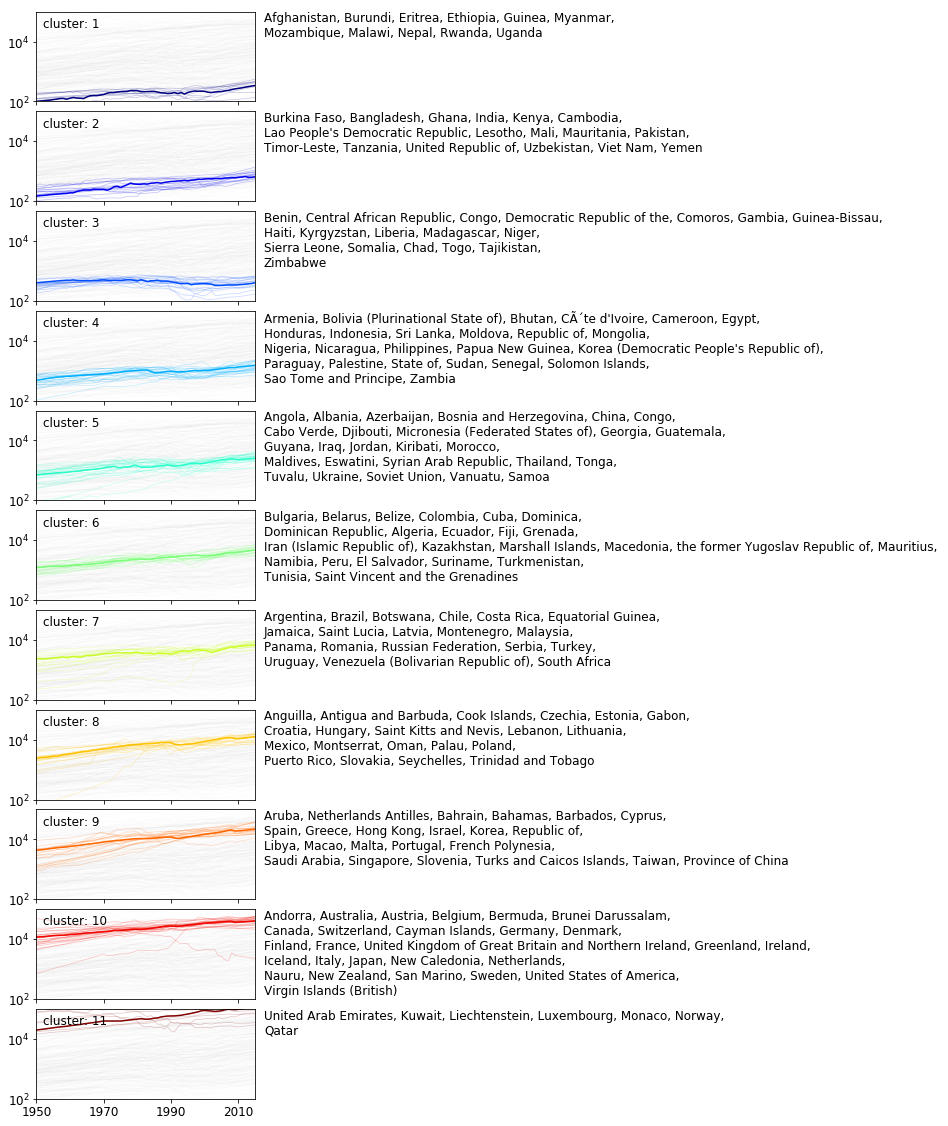

In [100]:
# TO HIDE

fig, axes = plt.subplots(11, 2, sharex = True, gridspec_kw = {'hspace' : 0.11, "wspace" : 0.04})
fig.set_size_inches(8, 20)

for idx, ax in enumerate(axes[:,0].flat):
    ax.set_xticklabels(['1950',  '1970', '1990', '2010'])
    plot_clusters(idx, df.values, results[9]['medoids'], results[9]['labels'], plt.cm.get_cmap('jet'), ax = ax)

for ax, (idx, group) in zip(axes[:,1], df_stats.groupby('label')['cname']):
    
    legend = print_n_in_line(group.values, 5)
    ax.text(0, 1, legend, horizontalalignment = 'left', verticalalignment = 'top')
    ax.set_axis_off()
plt.show()

The first four clusters collect countries whose GDPs remain low and the associated average annual growths are smaller than 2%. The next metacluster includes labels 5--10 where the mean GDP becomes progressively larger and the AAR is -- on average -- larger than 2%. The last group of cluster contains only one cluster. The majority of the timeseries represent a drecreasing trend. 

The primary separating dimension between clusters is the average value of the GDPs across years as shown in the figure below, where the clusters plotted against the mean and the average annual return (AAR). The AAR was chosen to represent the dynamics of the GDPs' evolution.  

In [101]:
# TO HIDE

from matplotlib.patches import Ellipse
from scipy.stats import chi2

def plot_cov_ellipse(X, p, ax = ax, color = 'red'):
    
    # iterate over groups
 

    mu1, mu2 = X.mean(axis = 0)
    
    covariance = np.cov(X, rowvar = False)
    w, v = np.linalg.eigh(covariance)
    
    r2 = chi2.ppf(p, covariance.shape[0])
    r2 = 3
    ax2, ax1 = 2 * np.sqrt(w * r2)
    
    # angle of rotation
    angle = np.degrees(np.arctan2(v[1,1], v[0,1]))

    # plot ellipse
    ellipse = Ellipse(xy = (mu1, mu2), width = ax1, height = ax2, angle = angle,
                      fill = True, edgecolor = color, alpha = 0.99, fc = 'None', lw = 1)
    ellipse.set_facecolor(color)
    ellipse.set_alpha(0.4)
    ax.add_patch(ellipse)
    
    # add scatter
    ax.scatter(group.values[:,0], group.values[:,1], 
               color = color, marker = '.', s = 10, alpha = 1)
    
    ax.scatter([mu1],[mu2], s= 100, marker = '+', color = 'black')

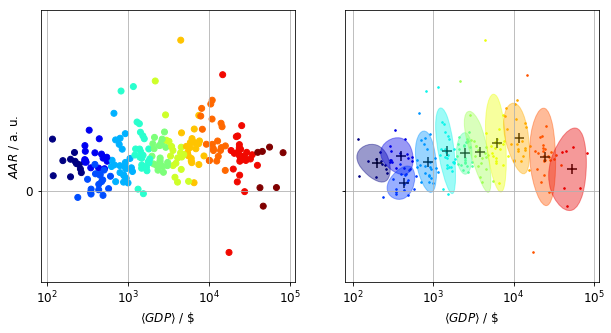

In [102]:
# TO HIDE

fig, axes = plt.subplots(1, 2, sharey = True)
fig.set_size_inches(10, 5)
axes[0].scatter(df_stats['mean'], df_stats['AAR'], color = plt.cm.get_cmap('jet')(df_stats['label']/10) )
axes[0].set_xscale('symlog')
axes[0].set_yscale('symlog')


axes[0].grid(True)
axes[0].set_xlabel(r'$\langle GDP \rangle$ / \$')
axes[0].set_ylabel(r'$AAR$ / a. u.')

axes[1].set_xscale('symlog')
axes[1].set_yscale('symlog')
axes[1].grid(True)
axes[1].set_xlabel(r'$\langle GDP \rangle$ / \$')

for idx, (_, group) in enumerate(df_stats.groupby(['label'])):
    plot_cov_ellipse(group[['mean', 'AAR']].values, 0.95, ax = axes[1], color = plt.cm.get_cmap('jet')(idx/11) )

plt.show()

Using the mean and the AAR to describe GDPs corresponds to a linear model, and as such it loses a wealth of information. This apparent from the statistics table below. The mean is a reasonably good separating variable, whereas the AAR has a rather poor discriminating power.

In [103]:
df_stats.groupby('label')[['mean', 'AAR']].describe().drop(['count', '25%', '75%'], axis = 1, level = 1)

mean                                                          \
               mean           std           min           50%           max   
label                                                                         
0        200.667123     51.618273    115.757428    216.478273    262.963111   
1        390.181510     97.923013    288.012800    365.500341    547.447041   
2        426.115283     92.886202    237.693017    431.601847    602.453659   
3        847.386273    144.170860    620.250145    874.343756   1127.438545   
4       1479.747107    237.391618    814.175010   1467.340734   1845.074602   
5       2490.528235    315.883235   1964.560733   2472.128227   3066.859439   
6       3827.121639    803.842542   2155.531905   3775.780500   5561.711500   
7       6300.830484   1052.993821   4450.766646   6115.175629   8619.286455   
8      11682.299887   2402.926593   7863.646803  11266.818530  15862.491985   
9      24691.065267   5082.077178  14681.687576  23907.654848  39449.978788   
10     54237.905693  15460.532122  39840.211061  46557.844697  81882.728182   

            AAR                                          
           mean       std       min       50%       max  
label                                                    
0      0.017625  0.006906  0.008979  0.017365  0.032888  
1      0.022100  0.006737  0.014136  0.020379  0.038545  
2      0.005278  0.006111 -0.004056  0.005978  0.016868  
3      0.018557  0.011233  0.005120  0.015508  0.049247  
4      0.025489  0.015684 -0.001702  0.022071  0.066189  
5      0.023795  0.007599  0.011861  0.022081  0.037412  
6      0.024806  0.014834  0.005628  0.023129  0.069728  
7      0.030364  0.017886  0.005252  0.027920  0.095589  
8      0.033281  0.012924  0.013057  0.029593  0.057549  
9      0.021609  0.017823 -0.038920  0.022235  0.073707  
10     0.013774  0.015100 -0.009593  0.024289  0.027826

## Future analysis

Ther are four main avenues to extend this short analysis

* Create features from the time series with regression models, tokenise the series
* Compare a manifold of distances, such as $L_{1}$, correlation
* Investigate other clustering methods, such as Markov clustering, affinity propagation
* Use biclustering which is more sensitive to the ordering of countries over time

## Appendix

### Misc functions

In [104]:
def calculate_lorenz_curve(X):
    """
    Calculates the Lorenz curve.
    Parameters:
        X (np.ndarray [pop_size, n_records]) : the wealth distribution over time.
    Returns:
        X_trf (np.ndarray [pop_size, n_records]) : Lorenz curve
    """

    X_trf = X.copy()
    X_trf = np.nancumsum(np.sort(X_trf, axis = 0), axis = 0) / np.nansum(X_trf, axis = 0)

    return X_trf

In [105]:
def calculate_gini(X):
    """
    Calculates the Gini coefficient.
    Parameters:
        X (np.ndarray [pop_size, n_records]) : the wealth distribution over time.
    Returns:
        gini_coeff (float) : Gini coefficient.
    """
    
    lc = calculate_lorenz_curve(X)
    pop_size = lc.shape[0]
    
    auc = np.sum(lc, axis = 0) / pop_size
    
    gini_coeff = 1.0 - 2.0 * auc
    
    return gini_coeff

In [106]:
def calc_entropy(X):
    """
    Calculates the normalised entropy along the last dimension.
    Parameters:
        X (np.ndarray [n_records, n_categories]) : observations
    Returns:
        entropy (np.ndarray [n_records]) : the normalised entropy
    """
    
    normed = normalize(X)
    
    logp = np.zeros(X.shape, dtype = np.float) 
    logp[normed != 0.0] = np.log(normed[normed != 0.0])
    
    entropy = -np.sum(logp * normed, axis = 1)
    entropy /= np.log(X.shape[1])
    
    return entropy

### k-medoids clustering

In [107]:
class KMedoids:
    """
    A slim implementation of the k-medoids algorithm.
    """
    
    def __init__(self, n_clusters = 8, n_init = 20, maxiter = 100):
        """
        Parameters:
            n_clusters (int) : number of clusters
            n_init (int) : number of restarts
            maxiter (int) : maximum number of iterations
        """
        
        self._n_clusters = n_clusters
        self._n_init = n_init
        self._maxiter  = maxiter
        self._labels = None
        self._medoids = None
         
    @property
    def labels_(self):
        return self._labels
    
    @property
    def medoids(self):
        return self._medoids
    
    @property
    def score(self):
        return self._score
        
    def fit(self, X):
        """
        Performs a clustering.
        
        Parameters:
            x (np.ndarray) : distance matrix
        Returns:
            self
        """
        
        # input check
        n_dim = X.ndim
        if n_dim != 2:
            raise ValueError("2D arrays expected. Got: {0}".format(n_dim))
            
        m, n = X.shape
        if n != m:
            raise ValueError("Square distance matrix expected.")
        
        # clear up from possible previous fit
        self._labels = None
        self._medoids = None
        
        # it can only better than this
        score_best = X.sum()
        
        # choose best from batch of fits
        for idx in range(self._n_init): 
            score_, labels_, medoids_ = self._single_fit(X)
            
            if score_ < score_best:
                score_best = score_
                self._medoids = medoids_
                self._labels = labels_
                self._score = score_best
        
        # relabel clusters
        labels = np.full_like(self._labels, -1)
        
        for idx, label in enumerate(self._medoids):
            labels[self._labels == label] = idx
        
        self._labels = labels
        
        return self
      
    def fit_predict(self, X):
        """
        Performs a clustering.
        Parameters:
            X (np.ndarray) : distance matrix
        Returns:
            self.labels_ (np.ndarray of int) : list of cluster labels
        """
        
        return self.fit(X).labels_
     
    def set_params(self, **params):
        """
        Sets the named parameters of the estimator.
        """
        
        for k, v in params.items():
            if k == "maxiter":
                self._maxiter = v
            
            elif k == "n_init":
                self._n_init = v
            
            elif k == "n_clusters":
                self._n_clusters = v
            
    def _single_fit(self, X):
        """
        Performs a single clustering.
        """
        
        medoids  = np.sort(np.random.choice(X.shape[0], self._n_clusters, replace = False))
        lookup = np.arange(X.shape[0])
        
        i_iter = 0
        
        while i_iter < self._maxiter:
            
            i_iter += 1
            d_min = X[medoids[0]] + 0 # deepcopy
            labels = np.full(X.shape[0], medoids[0])
            
            # maximisation step
            # assign datum to closest medoid
            for idx in medoids[1:]:
                mask = d_min > X[idx]
                d_min[mask] = X[idx][mask] + 0 # deepcopy
                labels[mask] = idx

            # expectation step
            # find new medoids

            is_converged = True

            for idx in range(self._n_clusters):
                mask = labels == medoids[idx]
                minidx = np.argmin(X[np.ix_(mask, mask)].sum(axis = 1))
                
                old_medoid = medoids[idx] + 0
                medoids[idx] = lookup[mask][minidx]
        
                is_converged &= medoids[idx] == old_medoid
        
            if is_converged:
                break
    
        # calculate cost function
        cost = d_min.sum()
            
        return cost, labels, medoids 